### Problem Statement:
What characteristics of a post on Reddit are most predictive of the overall interaction on a thread (as measured by number of comments)?

You will build a classification model that, using Natural Language Processing and any other relevant features, predicts whether or not a given Reddit post will have above or below the median number of comments.

In [132]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# import nltk
# from nltk.stem.porter import *
from  nltk.stem import PorterStemmer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report

In [2]:
rel_path_1 = ('datasets/pull_1.csv')
rel_path_2 = ('datasets/pull_2.csv')
rel_path_3 = ('datasets/pull_3.csv')
rel_path_4 = ('datasets/pull_4.csv')
rel_path_5 = ('datasets/pull_5.csv')

df_1 = pd.read_csv(rel_path_1)
df_2 = pd.read_csv(rel_path_2)
df_3 = pd.read_csv(rel_path_3)
df_4 = pd.read_csv(rel_path_4)
df_5 = pd.read_csv(rel_path_5)

df = pd.concat([df_1, df_2, df_3, df_4, df_5], ignore_index=True)

In [3]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [4]:
df.drop_duplicates(subset=['title'], keep='last', inplace=True)

In [5]:
df[df.title == '']

,title,num_comments,subreddit,length_time_seconds,length_time_days,created_utc,distinguished,Id,id_from_url,is_original_content,...,stickied,subreddit_subscribers,subreddit_type,total_awards_received,upvote_ratio,whitelist_status,locked,permalink,selftext,url


In [6]:
df.head()

,title,num_comments,subreddit,length_time_seconds,length_time_days,created_utc,distinguished,Id,id_from_url,is_original_content,...,stickied,subreddit_subscribers,subreddit_type,total_awards_received,upvote_ratio,whitelist_status,locked,permalink,selftext,url
0,Cops don't help,922,WhitePeopleTwitter,15512,0,1.653687e+09,NaN,uz8935,<function Submission.id_from_url at 0x7fb379c4...,False,...,False,2536345,public,11,0.94,some_ads,False,/r/WhitePeopleTwitter/comments/uz8935/cops_don...,NaN,https://i.redd.it/hmyphrd963291.jpg
1,Uvalde school police chief identified as comma...,2211,news,16502,0,1.653686e+09,NaN,uz7wjk,<function Submission.id_from_url at 0x7fb379c4...,False,...,False,24719718,public,1,0.97,all_ads,False,/r/news/comments/uz7wjk/uvalde_school_police_c...,NaN,https://www.cnn.com/us/live-news/texas-element...
2,Police didn't immediately confront the gunman ...,1124,nottheonion,15525,0,1.653687e+09,NaN,uz88xi,<function Submission.id_from_url at 0x7fb379c4...,False,...,False,21410253,public,2,0.97,all_ads,False,/r/nottheonion/comments/uz88xi/police_didnt_im...,NaN,https://www.insider.com/texas-shooting-police-...
3,The thin blue line,454,HolUp,15475,0,1.653687e+09,NaN,uz89iz,<function Submission.id_from_url at 0x7fb379c4...,False,...,False,3090734,public,9,0.95,some_ads,False,/r/HolUp/comments/uz89iz/the_thin_blue_line/,NaN,https://i.redd.it/8g06ywgd63291.jpg
4,Customer is upset that a mattress store won’t…...,577,ChoosingBeggars,20426,0,1.653682e+09,NaN,uz6jv0,<function Submission.id_from_url at 0x7fb379c4...,False,...,False,2315698,public,2,0.97,some_ads,False,/r/ChoosingBeggars/comments/uz6jv0/customer_is...,NaN,https://i.redd.it/p1tbj9lnr2291.jpg


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7190 entries, 0 to 7499
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7190 non-null   object 
 1   num_comments           7190 non-null   int64  
 2   subreddit              7190 non-null   object 
 3   length_time_seconds    7190 non-null   int64  
 4   length_time_days       7190 non-null   int64  
 5   created_utc            7190 non-null   float64
 6   distinguished          8 non-null      object 
 7   Id                     7190 non-null   object 
 8   id_from_url            7190 non-null   object 
 9   is_original_content    7190 non-null   bool   
 10  is_self                7190 non-null   bool   
 11  is_video               7190 non-null   bool   
 12  link_flair_text        3668 non-null   object 
 13  num_crossposts         7190 non-null   int64  
 14  over_18                7190 non-null   bool   
 15  scor

# Classification
Posts with likes above the median will be classified as 1 and below as 0

**Creating ```target```**  1 for posts with ```num_comments``` above median else zero

In [8]:
benchmark = df.num_comments.median()

In [9]:
df['target'] = [1 if num > benchmark else 0 for num in df.num_comments]

In [10]:
df['target'].value_counts(normalize=True)

0    0.501947
1    0.498053
Name: target, dtype: float64

- ```target``` = 0 (not 'hot') is the majority class 

---
---

# Data Cleaning

### Dropping Columns
- null values are addressed in this section of the notebook

**Dropping:**  ```distinguished```, ```id_from_url```, ```shortlink```, ```url```, ```link_flair_text```, ```selftext```
- These columns all had too many null values to be useful, so they were dropped.

In [11]:
df.drop(labels=['distinguished', 
                'id_from_url', 
                'shortlink', 
                'url', 
                'link_flair_text', 
                'selftext'], 
        axis=1, 
        inplace=True)

**Dropping:**   ```length_time_days```
- No posts were 'hot' for longer than a single day, so this feature is dropped. 

In [12]:
df.drop(labels=['length_time_days'], axis=1, inplace=True)

**Dropping:**  ```stickied```
- Very few posts were "stickied". This feature is not useful so it's being dropped. 

In [13]:
df.stickied.value_counts(normalize=True)

False    0.997357
True     0.002643
Name: stickied, dtype: float64

In [14]:
df.drop(labels=['stickied'], axis=1, inplace=True)

**```whitelist_status``` vs. ```over_18```**
- These features are related. All 112 posts with "promo_adult_nsfw" are listed as "over_18"
- ```whitelist_status``` has fewer posts in the aforementioned category than ```over_18```
- All other groups in ```whitelist_status``` have similar means 
- Because of these observations, ```whitelist_status``` is being dropped

In [15]:
df.whitelist_status.value_counts()

all_ads             5013
no_ads               938
some_ads             902
promo_adult_nsfw     112
Name: whitelist_status, dtype: int64

In [16]:
df.over_18.value_counts()

False    7020
True      170
Name: over_18, dtype: int64

In [17]:
df[(df.over_18 == True) & (df.whitelist_status ==  'promo_adult_nsfw')].title.count()

112

In [18]:
df.groupby('over_18')['num_comments'].median()

over_18
False    53.0
True     89.0
Name: num_comments, dtype: float64

In [19]:
df.groupby('whitelist_status')['num_comments'].median()

whitelist_status
all_ads             53.0
no_ads              51.0
promo_adult_nsfw    91.5
some_ads            59.0
Name: num_comments, dtype: float64

In [20]:
df.drop(columns='whitelist_status', axis=1, inplace=True)

In [21]:
df_info = pd.DataFrame({'nulls': [df[col].isna().sum() for col in df.keys()], 
                        'dtype': [df[col].dtype for col in df.keys()], 
                        'nunique_values': [df[col].nunique() for col in df.keys()], 
                        'unique_values': [df[col].unique()for col in df.keys()], 
                        'value_counts': [df[col].value_counts() for col in df.keys()]}, 
                        index=[col for col in df.keys()])
df_info

,nulls,dtype,nunique_values,unique_values,value_counts
title,0,object,7190,"[Cops don't help, Uvalde school police chief i...",Cops don't help ...
num_comments,0,int64,835,"[922, 2211, 1124, 454, 577, 953, 155, 462, 302...",13 106 20 101 12 100 21 9...
subreddit,0,object,1917,"[WhitePeopleTwitter, news, nottheonion, HolUp,...",Superstonk 22 WhitePeopleTwitter ...
length_time_seconds,0,int64,6668,"[15512, 16502, 15525, 15475, 20426, 21833, 123...",26257 4 37382 3 39575 3 24781 3 14...
created_utc,0,float64,7087,"[1653686766.0, 1653685776.0, 1653686753.0, 165...",1.653924e+09 2 1.653997e+09 2 1.653994e+...
Id,0,object,7190,"[uz8935, uz7wjk, uz88xi, uz89iz, uz6jv0, uz626...",uz8935 1 v11ugb 1 v0zpkw 1 v17rmx ...
is_original_content,0,bool,2,"[False, True]",False 7009 True 181 Name: is_original_...
is_self,0,bool,2,"[False, True]","False 6818 True 372 Name: is_self, dty..."
is_video,0,bool,2,"[False, True]","False 6019 True 1171 Name: is_video, dt..."
num_crossposts,0,int64,34,"[4, 2, 1, 0, 5, 7, 3, 6, 13, 23, 10, 14, 22, 3...",0 4933 1 1136 2 443 3 209 4 ...


In [22]:
df.groupby('is_self')['num_comments'].describe()

,count,mean,std,min,25%,50%,75%,max
is_self,,,,,,,,
False,6818.0,145.720006,366.783246,0.0,22.0,51.0,125.00,8579.0
True,372.0,563.973118,1633.164134,3.0,78.5,170.0,407.75,16731.0


## Addressing Outliers

**Target Outliers**
- In order to reduce the skew of our target, we removed ___ Rows from that had ```num_comments``` above 1200
- These posts were extreme outliers. This is only 2% of our dataset. 
- Our median nearly the same. 
- These posts most likely had other misleading features that could make our model less accurate. 

In [23]:
print(df.shape)
print(df[df.num_comments > 1200].title.count())

(7190, 20)
147


In [24]:
df.drop(index=df[df.num_comments > 1200].index, inplace=True)
df.reset_index(drop=True, inplace=True)

---
---

# Exploratory Data Analysis

In [25]:
df.subreddit.value_counts().head(30)

memes                   21
Superstonk              20
formula1                19
greentext               19
shitposting             19
MadeMeSmile             18
funny                   18
Eldenring               18
dankmemes               18
politics                17
ProgrammerHumor         17
PrequelMemes            17
Damnthatsinteresting    17
formuladank             17
HolUp                   17
oddlysatisfying         16
aww                     16
dndmemes                16
facepalm                16
WhitePeopleTwitter      16
nextfuckinglevel        15
PoliticalHumor          15
WitchesVsPatriarchy     15
interestingasfuck       15
antiwork                15
Genshin_Impact          15
tumblr                  15
BlackPeopleTwitter      15
Unexpected              15
pics                    14
Name: subreddit, dtype: int64

In [26]:
df.subreddit.nunique()

1915

In [27]:
df.subreddit.head()

0    WhitePeopleTwitter
1           nottheonion
2                 HolUp
3       ChoosingBeggars
4              antiwork
Name: subreddit, dtype: object

## Target

In [28]:
df.columns

Index(['title', 'num_comments', 'subreddit', 'length_time_seconds',
       'created_utc', 'Id', 'is_original_content', 'is_self', 'is_video',
       'num_crossposts', 'over_18', 'score', 'spoiler',
       'subreddit_subscribers', 'subreddit_type', 'total_awards_received',
       'upvote_ratio', 'locked', 'permalink', 'target'],
      dtype='object')

In [29]:
df.num_comments.describe()

count    7043.000000
mean      115.036632
std       171.177750
min         0.000000
25%        22.000000
50%        52.000000
75%       126.000000
max      1199.000000
Name: num_comments, dtype: float64

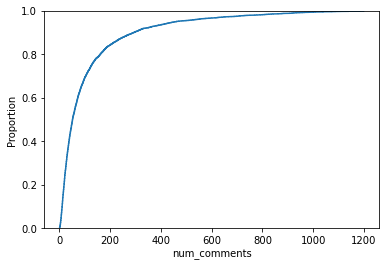

In [30]:
sns.ecdfplot(data=df, x='num_comments');

''

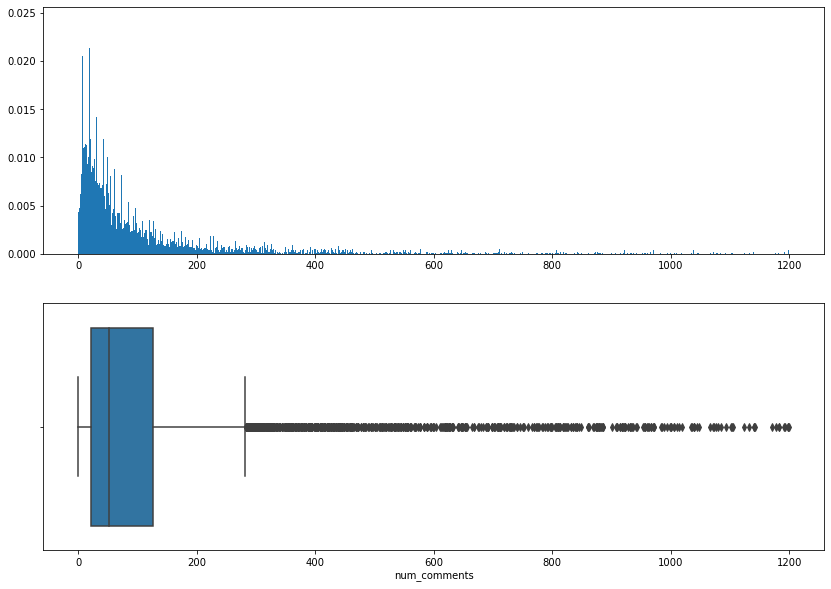

In [31]:
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

ax[0].hist(df.num_comments, 1000, density = True, 
         histtype ='bar')
sns.boxplot(x='num_comments', data=df, ax=ax[1])           
;

**```upvote_ratio``` vs. ```num_comments```**
- This feature does not have a correlation with the target. 
- It is interesting that posts with low```num_comments``` have high ```upvote_ratio``` for the most part. This may be because the algorithm that Reddit uses to classify posts as "hot" gives this feature significant weight. 
- For our model that compares the ```num_comments``` for a post relative to the median, this feature will not be useful in our model. This feature is being dropped. 

In [32]:
round(np.corrcoef(df.num_comments, df.upvote_ratio)[0, 1], 3)

-0.472

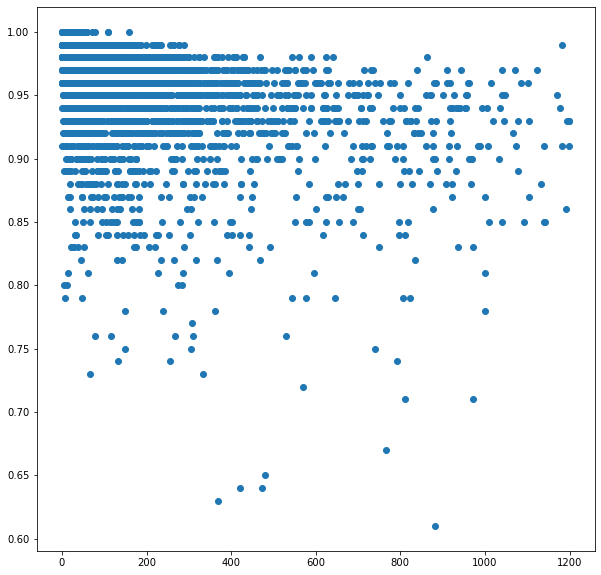

In [33]:
fix, ax = plt.subplots(figsize=(10, 10))

ax.scatter(df.num_comments, df.upvote_ratio);

In [34]:
df.drop(labels=['upvote_ratio'], axis=1, inplace=True)

---
---

# Natural Language Processing

## NLP Text Cleaning

**Normalize All Text to Lowercase**

In [ ]:
# title
# df.title = [string.lower() for string in df.title]
# subreddit
# df.subreddit = [string.lower() for string in df.subreddit]

**Remove Emojis**
- Removing Unicode Characters

In [ ]:
# import emoji

# def give_emoji_free_text(self, text):
#     allchars = [str for str in text]
#     emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
#     clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])

#     return clean_text

# text = give_emoji_free_text(df.iloc[17].title)

**Removing Stop Words**

## Stemming with NLTK

In [75]:
# stemmer = PorterStemmer()
# df['stemmed_title'] = [' '.join([stemmer.stem(word) for word in sentence.split(' ')]) 
#                        for sentence in df.title]

In [76]:
# df.stemmed_title

0                                          cop don't help
1       polic didn't immedi confront the gunman as tex...
2                                      the thin blue line
3       custom is upset that a mattress store won’t… h...
4                           cop tri to join the movement.
                              ...                        
7038                                                   hi
7039                                 "crawlerfield" by me
7040                   whi do i continu to tortur myself?
7041    kabinet zet dure traditi voort: de klm redden ...
7042                  you just don’t know what you’r miss
Name: stemmed_title, Length: 7043, dtype: object

## Unprocessed Model

### Train Test Split

In [101]:
X = df['title']
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=73)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5634,) (5634,)
(1409,) (1409,)


### TfidfVectorizer

In [102]:
tvec = TfidfVectorizer(stop_words = 'english',
                       strip_accents = 'ascii',
                       max_features = 50,
                       max_df = .60,
                       norm = 'l2'
                      )
tvec.fit(X_train)

TfidfVectorizer(max_df=0.6, max_features=50, stop_words='english',
                strip_accents='ascii')

In [103]:
train_tvec = pd.DataFrame(tvec.transform(X_train).todense(),
                          columns = tvec.get_feature_names()
                         )
train_tvec['target'] = y_train.values

tvec.transform(X_test).todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [104]:
train_tvec.head()

,2022,art,best,cat,day,did,does,dog,don,finally,...,think,thought,time,today,want,way,world,year,years,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


### KNN Model 

In [105]:
# baseline model. mean of target
df.target.value_counts(normalize=True)

0    0.512424
1    0.487576
Name: target, dtype: float64

In [106]:
train_scores = cross_val_score(KNeighborsClassifier(n_jobs=-1, 
                                                    n_neighbors=9
                                                   ), 
                               train_tvec.drop('target', axis=1), 
                               train_tvec.target 
                              )

In [108]:
print('Cross val scores:', train_scores)
print('Mean:', round(train_scores.mean(), 3))
print('Stdev:', round(2 * train_scores.std(), 3), '\n')

Cross val scores: [0.53771074 0.53238687 0.52440106 0.49511979 0.48667851]
Mean: 0.515
Stdev: 0.041 



In [107]:
# test_scores = cross_val_score(KNeighborsClassifier(n_jobs=1, n_neighbors=9), 
#                               test_tvec.drop('target', axis=1), 
#                               test_tvec.target 
#                              )

In [109]:
# print('Cross val scores:', test_scores)
# print('Mean:', round(test_scores.mean(), 3))
# print('Stdev:', round(2 * test_scores.std(), 3), '\n')

## Stemming with NLTK

In [110]:
stemmer = PorterStemmer()
df['stemmed_title'] = [' '.join([stemmer.stem(word) for word in sentence.split(' ')]) 
                       for sentence in df.title]

In [111]:
df.stemmed_title.head()

0                                       cop don't help
1    polic didn't immedi confront the gunman as tex...
2                                   the thin blue line
3    custom is upset that a mattress store won’t… h...
4                        cop tri to join the movement.
Name: stemmed_title, dtype: object

## Stemmed Model

### Train Test Split

In [157]:
X = df['stemmed_title']
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=73)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5634,) (5634,)
(1409,) (1409,)


### Stemmed TfidfVectorizer

In [158]:
tvec = TfidfVectorizer(stop_words = 'english',
                       strip_accents = 'ascii',
                       max_features = 50,
                       max_df = .60, # penalizign tokens that are way too freq
                       norm = 'l2' # normalizing using ridge
                      )
tvec.fit(X_train)

TfidfVectorizer(max_df=0.6, max_features=50, stop_words='english',
                strip_accents='ascii')

In [159]:
train_tvec = pd.DataFrame(tvec.transform(X_train).todense(),
                          columns = tvec.get_feature_names()
                         )
train_tvec['target'] = y_train.values
train_tvec.head()

,2022,art,best,cat,come,day,did,don,final,friend,...,tri,use,wa,want,way,whi,work,world,year,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [160]:
test_tvec = pd.DataFrame(tvec.transform(X_test).todense(),
                          columns = tvec.get_feature_names()
                         )
test_tvec['target'] = y_test.values
test_tvec.head()

,2022,art,best,cat,come,day,did,don,final,friend,...,tri,use,wa,want,way,whi,work,world,year,target
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.701945,0.0,0.0,0.0,0.0,0.0,0.712231,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [161]:
train_tvec.columns.difference(test_tvec.columns)

Index([], dtype='object')

### KNN Stemmed Model 

In [162]:
# baseline model. mean of target
df.target.value_counts(normalize=True)

0    0.512424
1    0.487576
Name: target, dtype: float64

In [163]:
knn = KNeighborsClassifier(n_neighbors=9, n_jobs=-1)

train_scores = cross_val_score(knn, 
                               train_tvec.drop('target', axis=1), 
                               train_tvec.target 
                              )

In [164]:
print('Cross val scores:', train_scores)
print('Mean:', round(train_scores.mean(), 3))
print('Stdev:', round(2 * train_scores.std(), 3), '\n')

Cross val scores: [0.54835847 0.53593611 0.52351375 0.50133097 0.54884547]
Mean: 0.532
Stdev: 0.036 



In [168]:
knn = KNeighborsClassifier(n_neighbors=9, n_jobs=-1)
knn.fit(train_tvec.drop('target', axis=1), y_train)

predicted = knn.predict(test_tvec.drop('target', axis=1))
confusion_matrix(y_test, predicted)

array([[595, 161],
       [465, 188]])

In [193]:
y_pred = knn.predict(test_tvec.drop('target', axis=1))

conmat = np.array(confusion_matrix(y_test, y_pred, labels=[0, 1]))

confusion = pd.DataFrame(conmat, index=['true_0', 'true_1'], columns=['pred_0', 'pred_1'])
confusion

,pred_0,pred_1
true_0,595,161
true_1,465,188


In [194]:
from sklearn.metrics import ConfusionMatrixDisplay

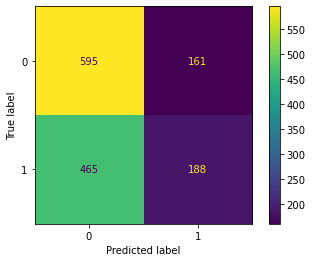

In [199]:
matrix_display = ConfusionMatrixDisplay(confusion_matrix=conmat, 
                                        display_labels=knn.classes_)
matrix_display.plot();

In [209]:
print(classification_report(y_test, y_pred, target_names=['not_hot', 'hot']))

              precision    recall  f1-score   support

     not_hot       0.56      0.79      0.66       756
         hot       0.54      0.29      0.38       653

    accuracy                           0.56      1409
   macro avg       0.55      0.54      0.52      1409
weighted avg       0.55      0.56      0.53      1409



In [175]:
# knn.score(test_tvec.drop('target', axis=1), y_test)

0.5557132718239887

## Logistic Regression Model

# Conclusion

# Recommendation

### Problem Statement:
What characteristics of a post on Reddit are most predictive of the overall interaction on a thread (as measured by number of comments)?

You will build a classification model that, using Natural Language Processing and any other relevant features, predicts whether or not a given Reddit post will have above or below the median number of comments.

### Requirements

Create and compare two models. One of these must be a random forest, however the other can be a classifier of your choosing: logistic regression, KNN, SVM, etc.

A Jupyter Notebook with your analysis for a peer audience of data scientists

An executive summary of the results you found

A 4 minute presentation outlining your process and findings for a semi-technical audience. The reason we say 'semi-technical' is that FiveThirtyEight wants to see how you plan to explain your findings in your article, and their audience is likely readers who are familiar with and interested in data/statistics, but are not experts. This means that if you'd like to talk about your model works you can, but explain what exactly your model does at a high-level.